In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd 'drive/MyDrive/Soil Classification Project/Working_Data'

/content/drive/MyDrive/Soil Classification Project/Working_Data


In [1]:
# Preprocessing on dataset
import cv2 as cv
import zlib
import base64
import numpy as np
import os
import pandas as pd
from tqdm import tqdm
from itertools import product
import datetime as dt
import ast
import empiricaldist
from scipy.signal import hamming
import math as mt
import scipy
import statistics as st

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# Machine Learning
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

#Deep Learning
#import tensorflow as tf
#import tensorflow_hub as hub
#import keras

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score, make_scorer
# Parameter tuning

# Variables to run
#tf.config.run_functions_eagerly(True)
#tf.experimental.numpy.experimental_enable_numpy_behavior()


In [2]:
## Implement sharpening and check performance of fourier, it behaved wrong after denoising the sand image which is expected. 
## Implement the primitive color indication on a normalized and unnormalized level. I might let the models decide which they
## prefer. I hope sharpening solves the naive particle estimation problem

## Generating Images used in the Paper

In [3]:
test_image = cv.imread('test_data/2 inches at 1 ft/WhatsApp Image 2024-08-24 at 09.42.34.jpeg')
#test_image = cv.imread('test_data/old stone dust/IMG_9411.jpg')
#test_image = cv.imread('Data/Nsukka-Gravel/Bigger-Size/Close-Range-25-30cm/20240204_101240.jpg')
#test_image = cv.imread('Data/Nsukka-Gravel/Smaller-Size/Close-Range-20-30cm/20240204_102340.jpg')
#test_image = cv.imread('Data/Red-Sand/Close-Range-20cm-30cm/IMG_6932.jpeg')
#test_image = cv.imread('Data/White-Sand/Close-Range-25-30cm/20240201_071815.jpg')

In [4]:
# Step 1. GrayImage

# Converting to RGB
test_image = cv.cvtColor(test_image, cv.COLOR_BGR2RGB)

# Converting to grayscale
test_image_gray = cv.cvtColor(test_image, cv.COLOR_RGB2GRAY)

# Checking image type 
print('dtype is {}'.format(test_image_gray.dtype))

#uint8 so max value should be < 255
print('Max value is {}'.format(np.max(test_image_gray)))

dtype is uint8
Max value is 255


Text(0.5, 1.0, 'Reduced Image')

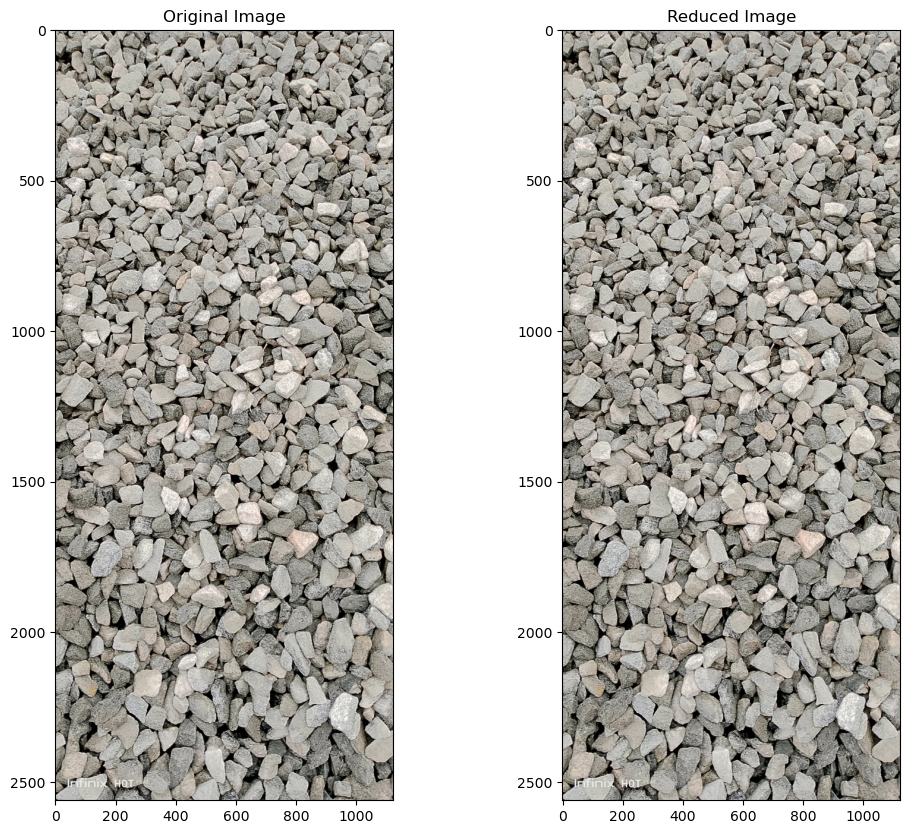

In [27]:
plt.figure(figsize=(12, 10))
plt.subplot(121), plt.imshow(test_image, cmap='gray')
plt.title('Original Image')
plt.subplot(122), plt.imshow(df['matrix'][0], cmap='gray')
plt.title('Reduced Image')

In [5]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/GrayScale.jpg', test_image_gray)

In [6]:
# Step 2. Median Filtering
#median = cv.medianBlur(test_image_gray, 3)
#bi = cv.bilateralFilter(test_image_gray, 5, 200, 200)

#gaus_blur=cv.GaussianBlur(median, (5,5), 2)

In [7]:
# Step 3. Image Sharpening
#sharp=cv.addWeighted(median, 4.5, gaus_blur, -3.5, 0)
#cv.imwrite('bi_sand.jpg', sharp)

In [8]:
# Step 4. Resizing Image
gray_resized = cv.resize(test_image_gray, (500,500))
print('dtype is {}'.format(gray_resized.dtype))

dtype is uint8


In [9]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/Resize.jpg', gray_resized)

Text(0, 0.5, 'Pixel Percentage (%)')

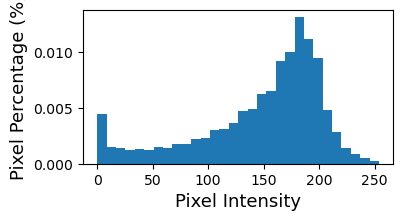

In [10]:
# Visualizing Histogram before equalization
plt.figure(figsize=(4, 2))
plt.hist(gray_resized.flatten(), bins=30, density=True)
plt.xlabel('Pixel Intensity', fontsize=13)
plt.ylabel('Pixel Percentage (%)', fontsize=13)
#plt.savefig('Pixel_distr_before_equal.jpg', dpi=800)

In [11]:
# Step 5 - Histogram Equalization
hist_equ = cv.equalizeHist(gray_resized)
print('dtype is {}'.format(hist_equ.dtype))

dtype is uint8


Text(0, 0.5, 'Pixel Percentage (%)')

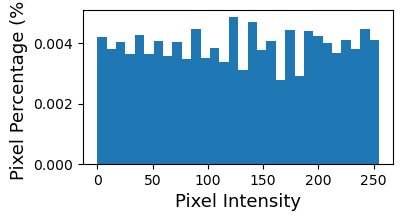

In [12]:
# Viewing the distribution again
plt.figure(figsize=(4, 2))
plt.hist(hist_equ.flatten(), bins=30, density=True)
plt.xlabel('Pixel Intensity', fontsize=13)
plt.ylabel('Pixel Percentage (%)', fontsize=13)
#plt.savefig('Pixel_distr_after_equal.jpg', dpi=800)

## Compared to the previous plot, the pixel values here are more distributed.

In [13]:
# Step 6. Blending
blended = 0.3*gray_resized + 0.7*hist_equ

# Changing to Uint8
blended = np.uint8(blended)

#blended=get_sharpened_image(blended, alpha=2, beta=-1.5)

print(blended.max(), blended.shape)
print('dtype is {}'.format(blended.dtype))

254 (500, 500)
dtype is uint8


In [14]:
# a bit of advice, when performing arithemetics on images, it's important to do with great care. For example doing 200/2+200/2
# is different from (200+200)/2 first answer is 200 second is 72 because since 200+200 > 256, we get a modulo returned
# 400 mod256=144 and divided by 2 is 72 as shown below

# to avoid, we can cast first or just scale independently such that scale sums to 1 e.g b*0.5+b*0.5 or convert
# data type e.g result = (b.astype(float) + b.astype(float)) / 2

# I also noticed that in python, now we have b as uint8, any arithemetic like /2 takes into float but direct operation like 
# b+b, we stil get as uint 8


In [419]:
b = blended*0 + 200
b.dtype

dtype('uint8')

In [393]:
(b/2+b/2)

array([[200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       ...,
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.],
       [200., 200., 200., ..., 200., 200., 200.]])

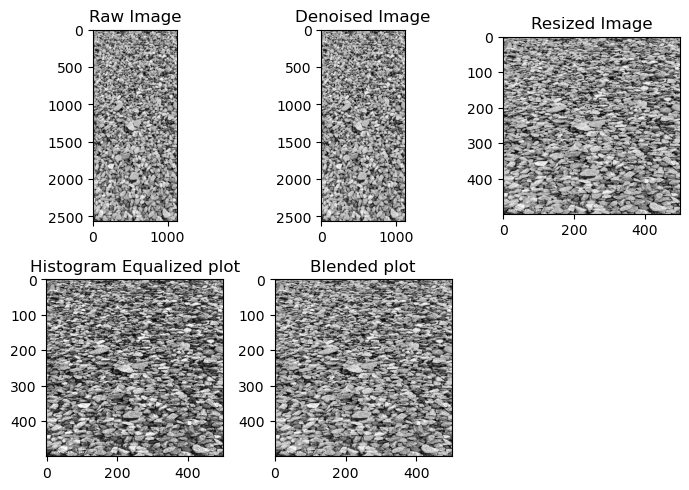

In [141]:
# All preprocessing vizualization
plt.figure(figsize=(7, 5))
plt.subplot(231), plt.imshow(test_image_gray, cmap='gray')
plt.title('Raw Image')
plt.subplot(232), plt.imshow(median, cmap='gray')
plt.title('Denoised Image')
plt.subplot(233), plt.imshow(gray_resized, cmap='gray')
plt.title('Resized Image')
plt.subplot(234), plt.imshow(hist_equ, cmap='gray')
plt.title('Histogram Equalized plot')
plt.subplot(235), plt.imshow(blended, cmap='gray')
plt.title('Blended plot')
plt.tight_layout()
plt.show()

In [ ]:
#cv.imwrite('Plans and Paper/Paper Images/Methodology/blended.jpg', blended)

## Using Fourier transform
Idea was to use median row pixels value to give a sense of edge positioning in the sense smaller pixels might have more edges thus composing like 50% (median) of the row pixel value but better still, since this is basically a thing of frequency in the sense smaller stones should have many high frequency regions, I can do this same thing with fourier transforms.

### Expected Behaviours
1. Big stones - I expect a bigger white region in the middle since it has more low frequencies and less high frequencies or say less edges.
2. Small stones - I expect a smaller white region in the middle for the opposite region.



In [3]:
# Feature Engineering Functions

def get_color(rgb_image, normalize=True):

    # Find the index of the maximum value for each pixel along the RGB axis
    max_index = np.argmax(rgb_image, axis=-1)
    
    # Convert to float32 to avoid overflow during division
    rgb_image = rgb_image.astype(np.float32)

    # Find the maximum value in image
    _max = np.max(rgb_image)
    
    normalized_image = rgb_image/_max

    # Create an array where we will store the thousand values
    thousand_values = np.zeros_like(max_index)

    # Assign 1000 to pixels where red is max, 2000 for green, and 3000 for blue
    thousand_values[max_index == 0] = 1000  # Red channel
    thousand_values[max_index == 1] = 2000  # Green channel
    thousand_values[max_index == 2] = 3000  # Blue channel

    # Get the maximum pixel value per channel (if normalize is true, normalize the layers, normalize isn't implemented yet)
    if normalize is True:
        max_rgb_values = np.max(normalized_image, axis=-1)
    else:
        max_rgb_values = np.max(rgb_image, axis=-1)

    # Add the thousand values to the maximum RGB values
    result = max_rgb_values + thousand_values

    # Extract percentiles to get an idea of the dominant color
    return [np.percentile(result, perc) for perc in range(10, 101,10)]

def get_fourier_radius(fourier_image, r=125):
    rows, cols = fourier_image.shape
    crow, ccol = int(rows / 2), int(cols / 2)

    center = [crow, ccol]
    
    #ogrid creates arrays with values specified in braces e.g x, y = np.ogrid[:5, :5] creates first array with 5 rows of 0-5
    #and second array with 5 columns of 0-5
    x, y = np.ogrid[:rows, :cols]
    # this is simply the formula of a circle, it's very crucial to subtract the half of the shape in this equation as it makes
    # the centroid index value gotten from ogrid to be 0 and note that we use the truth table to filter from main image
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= r*r
    mask_area = fourier_image[mask_area]
    med=np.median(mask_area)
    return med

def get_fourier_distribution(fourier_image):
    return [np.percentile(fourier_image, perc) for perc in range(0, 101,10)]

'''def apply_window(image):
    # Get the image size
    h, w = image.shape
    # Generate Hamming window
    window = np.outer(hamming(h), hamming(w))
    # Apply window
    return image * window'''

def get_sharpened_image(image, alpha=2.5, beta=-1.5, gamma=0, sigma=2, sharp_scale=1, blur_scale=0):
    gaus_blur=cv.GaussianBlur(image, (5,5), sigma)
    sharpened=cv.addWeighted(image, alpha, gaus_blur, beta, gamma)
    #plt.imshow(sharpened*sharp_scale + gaus_blur*blur_scale, cmap='gray')
    #plt.show()
    #print('KK')
    return sharpened*sharp_scale + gaus_blur*blur_scale

def get_fourier(image, visualize=True):
    image = cv.imread('test_data/'+image)
    
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    color_image=image
    color_image = cv.resize(color_image, (500,500))

    # 1. Converting to grayscale
    image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    #print(image.shape)
    
    #Apply Median Filtering
    #image = cv.medianBlur(image, 5)
    #image=cv.GaussianBlur(img1_resized, (5, 5), 0)
        
    # 2. Resizing
    image_grz = cv.resize(image, (500,500))
    #median = cv.medianBlur(image_grz, 3)
    #bi = cv.bilateralFilter(test_image_gray, 5, 200, 200)
    
    # 3. Histogram Equalization
    image = cv.equalizeHist(image_grz)
    image = 0.3*image_grz + 0.7*image

    # 4. Sharpen image
    #gaus_blur=cv.GaussianBlur(image_grz, (5,5), 2)
    image=get_sharpened_image(image_grz)
    # add weighted is basically applying a formula dst=α⋅src1+β⋅src2+γ(0 in this case)
    #cv.imwrite('tt.jpg', image)
    #image=cv.GaussianBlur(image_grz, (5, 5), 0)
    #image = cv.medianBlur(image_grz, 5)

    # 5. Changing to Uint8
    image = np.uint8(image)
    #image=apply_window(image)
    
    # Perform the 2D Fourier Transform
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]))
    #mag=magnitude_spectrum[250,200:250]

    # Display the original image and its magnitude spectrum
    if visualize==True:
        plt.figure(figsize=(7,5))
        plt.subplot(131), plt.imshow(color_image, cmap='gray')
        plt.title('Color Image'), plt.axis('off')
        plt.subplot(132), plt.imshow(image, cmap='gray')
        plt.title('Gray Image'), plt.axis('off')
        plt.subplot(133), plt.imshow(magnitude_spectrum, cmap='gray')
        plt.title('Magnitude Spectrum'), plt.axis('off')
        plt.show()
    else:
        pass
    
    return magnitude_spectrum

def remove_small_skeletons(thinned_image, Tlength):
    _, labels = cv.connectedComponents(thinned_image)

    # The number of labels is max label + 1 since we do 0 indexing
    num_labels = labels.max() + 1
    kept_labels=0
    #print(num_labels)

    # We create a list to store the skeletons or say the skeleton images where the >= Tlength condition is satisfied
    skeletons = []

    for label in range(1, num_labels):  # Exclude background (label 0)
        # We loop through all the labels and the variable "component" just creates an image where only pixels from a
        # Particular label is shown
        component = (labels == label).astype(np.uint8)
        #print(component)


        # Below after getting all pixels from each label, we sum the pixels from the labels and use basically if the sum
        # of the skeleton from a particular label is small, we take it as noise which makes a whole lot of sense.
        if np.sum(component) >= Tlength:
            skeletons.append(component)
            kept_labels+=1
            #plt.imshow(component)
            #plt.show()

    # Create a new thinned image with the remaining skeletons - we basically join all the skeletons in the skeleton list
    # The skeleton list is where we kept the pixels with long lengths
    thinned_image = np.zeros_like(thinned_image)
    for skeleton in skeletons:
        thinned_image |= skeleton  # Use logical OR to combine skeletons

    return thinned_image, num_labels, kept_labels

def crop_to_square(image):
    """
    Crops the center of an image to make it square if one dimension is 30% larger than the other.
    
    Parameters:
    image (numpy array): Input image as a NumPy array (HxWxC or HxW).
    
    Returns:
    cropped_image (numpy array): Cropped square image.
    """
    # Get the dimensions of the image
    height, width = image.shape[:2]
    #2560, 1123
    # Check if one side is 30% or more larger than the other
    if height >= width * 1.3 or width >= height * 1.3:
        # Determine the smaller dimension
        smaller_dim = min(height, width)
        #print(smaller_dim)
        
        # Calculate the crop coordinates for a centered square
        if height > width:  # Crop height
            top = (height - smaller_dim) // 2
            bottom = top + smaller_dim
            left, right = 0, width
            #print(top,bottom,left,right)
        else:  # Crop width
            left = (width - smaller_dim) // 2
            right = left + smaller_dim
            top, bottom = 0, height
        
        # Crop the image
        cropped_image = image[top:bottom, left:right]
        return cropped_image
    else:
        # If no cropping is needed, return the original image
        return image

# Other Functions
def add_patch(x,y, dist_x, dist_y):
    plt.gca().add_patch(Rectangle((x,y),dist_x,dist_y,
                    edgecolor='red',
                    facecolor='none',
                    lw=3))

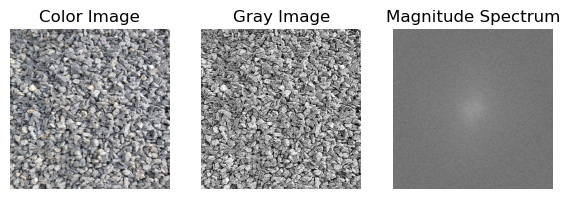

In [4]:
# new proper training data
m11= get_fourier('test-proper-big-far.jpg')
f11=get_fourier_radius(m11,20)

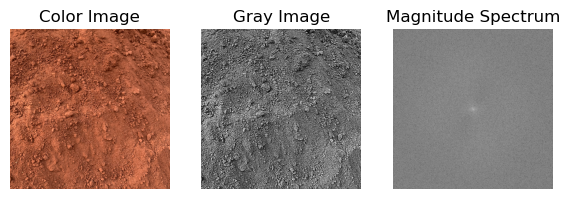

In [119]:
m13=get_fourier('smallest.jpeg')
f13=get_fourier_radius(m13,20)

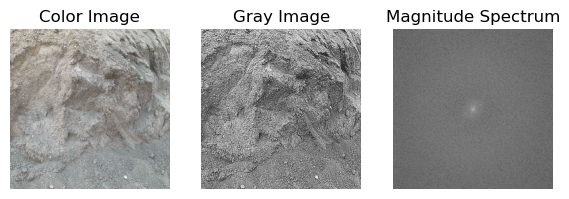

In [121]:
# smallest
m1= get_fourier('old stone dust/IMG_9411.jpg')
f1=get_fourier_radius(m1,20)

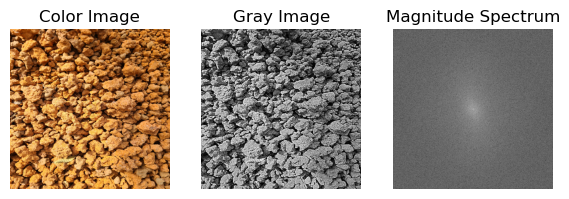

In [124]:
# big
m4= get_fourier('big.jpg')

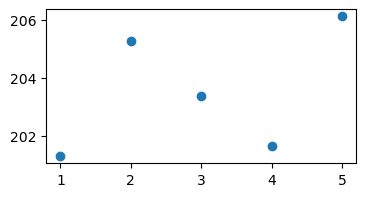

In [126]:
# The mag value returned is the magnitute spectrum in position [250,200:250] or say the middle of the images.
# The idea is that the middle region should have a wider range of low intensity values for big images or in other words
# bigger values for a wider radius and for smaller stones big values for a small radius. So, the median should be smaller
# in the small stones.

# Updated on 6th October 2024
# It seems my understanding was wrong, I think the case is that we'll have slightly larger circles or it could even be 
# considerably larger but also the centers are more populated or say filled up but for small particles, it's either it's
# just bright at one point like a very small region of low frequency or it's bright for a wide range but not very filled
# as such, a smaller radius needs to be used in the model testing.

# We'll be using a circular radius for this extraction and testing for the optimal circular radius
plt.figure(figsize=(4,2))
plt.scatter(list(range(1,6)), [np.median(m1), np.median(m2), np.median(m3), np.median(m4), np.median(m5)])

# note that image 5 is expected to have an issue, see next cell

In [16]:
sh=get_sharpened_image(blended, alpha=2.5, beta=-1.5, gamma=20)
# Gamma does a bit of brightening actually, I'll also experiment that

# Changing to Uint8
#blended = np.uint8(blended)

In [17]:
# Appling Canny Edge Detection
canny_edge_img = cv.Canny(sh, 400, 800, L2gradient=True)

In [22]:
# might consider as noise reduction approach yupp
#thinned = cv.ximgproc.thinning(blended)
thinned=remove_small_skeletons(canny_edge_img, 5)

3044


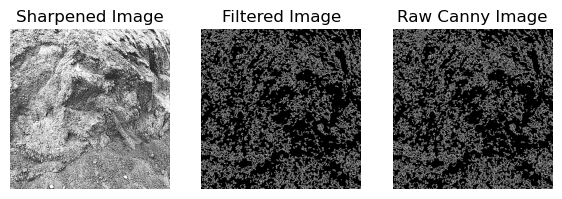

In [19]:
# Visualizing blended image
plt.figure(figsize=(7,5))
plt.subplot(131), plt.imshow(sh, cmap='gray')
plt.title('Sharpened Image'), plt.axis('off')
plt.subplot(132), plt.imshow(thinned, cmap='gray')
plt.title('Filtered Image'), plt.axis('off')
plt.subplot(133), plt.imshow(canny_edge_img, cmap='gray')
plt.title('Raw Canny Image'), plt.axis('off')
plt.show()

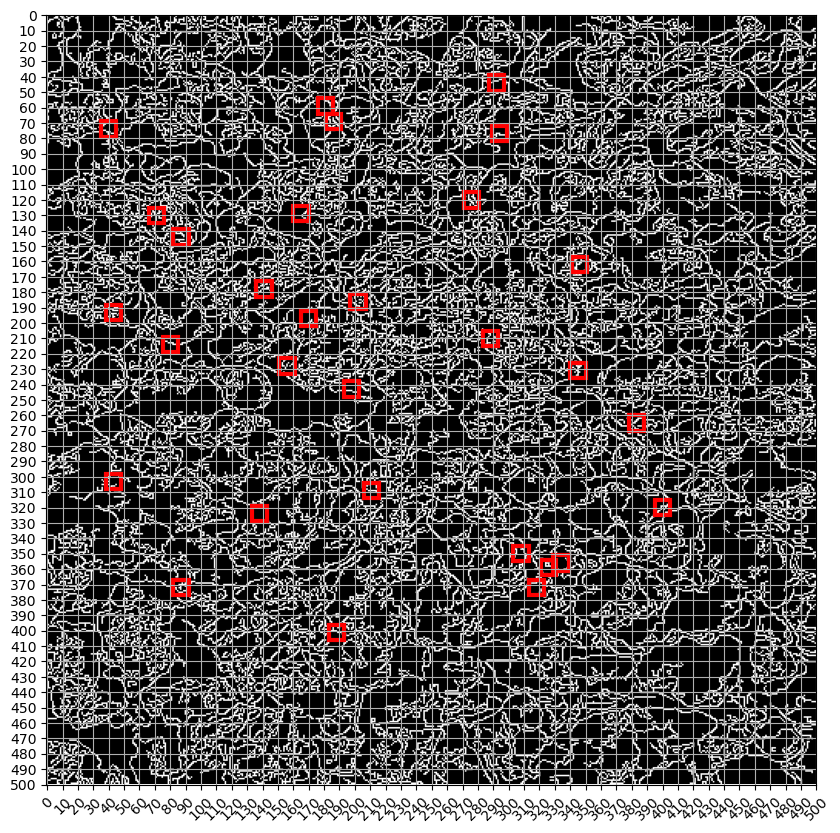

In [ ]:
# Generating random positions
np.random.seed(30)
x=np.random.randint(20, 400, 30)
y=np.random.randint(20, 400, 30)

# Visualizing canny edge image
plt.figure(figsize=(7,5))
plt.imshow(canny_edge_img, cmap='gray')
for corr_x, corr_y in zip(x,y):
    add_patch(corr_x, corr_y, 10, 10)
plt.xticks(range(0,501,10), rotation=45)
plt.yticks(range(0,501,10))
plt.grid()
#plt.savefig('Naive_particle_size.jpg', dpi=800)

One thing I've observed from numpy arrays is the dimensions are the latest i.e (3x10x2) means we have 3 dimensions of (10) rows by 2 columns

## Extra Functions

In [4]:
def generate_perc_dist_columns(perc_distance=5, color_cols=True, fourier=True):
    col_names=['perc_'+str(dist) for dist in range(1,101,perc_distance)]
    col_names.append('mode')
    #col_names.append('distance')
    
    if color_cols == True:
        for c in range(10,101,10):
            col_names.append('color_percentile_'+str(c))
    if fourier==True:
        for four_ in range(0,101,10):
            col_names.append('fourier_distribution_'+str(four_))
        col_names.append('fourier_median')
    return col_names

In [5]:
def preprocess_v2(image_path, canny_x=100, canny_y=350, blend_x=0.7, blend_y=0.3, alpha=2.5, beta=-1.5, gamma=20, Tlength=5,
                 sigma=2, sharp_scale=1, blur_scale=0, square=True):
    '''Returns all the necessary images for further preprocessing'''
    
    image = cv.imread(image_path)
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    color_image=image

    # Converting to grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    
    # Squaring image before further preprocessing
    if square == True:
        image_gray=crop_to_square(image_gray)
    else:
        pass
        
    # Resizing image
    gray_resized = cv.resize(image_gray, (500,500))

    # histogram equalization
    hist_equ = cv.equalizeHist(gray_resized)
    blended = blend_x*gray_resized + blend_y*hist_equ
    
    # sharpening the image
    sharp=get_sharpened_image(blended, alpha=alpha, beta=beta, gamma=gamma, sigma=sigma, sharp_scale=sharp_scale,
                             blur_scale=blur_scale)
    
    # converting to uint 8 0-255 pixel value
    sharp = np.uint8(sharp)
    #plt.imshow(blended, cmap='gray')
    #plt.show()

    # Appling Canny Edge Detection
    canny_edge_img = cv.Canny(sharp, canny_x, canny_y, L2gradient=True)
    canny_edge_img_unit = canny_edge_img/255
    
    # Perform the 2D Fourier Transform
    dft = cv.dft(np.float32(sharp), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)  # Shift the zero frequency component to the center

    # Calculate the magnitude spectrum
    magnitude_spectrum = 20 * np.log(cv.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]))
    
    # length filtering
    thinned, lab, kept =remove_small_skeletons(canny_edge_img, Tlength)
    #plt.imshow(thinned)
    #plt.show()

    return thinned, magnitude_spectrum, color_image, lab, kept

In [6]:
def preprocess(image_path, canny_x=100, canny_y=350, blend_x=0.7, blend_y=0.3):
    image = cv.imread(image_path)
    
    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    # Converting to grayscale
    image_gray = cv.cvtColor(image, cv.COLOR_RGB2GRAY)

    # Resizing image
    gray_resized = cv.resize(image_gray, (500,500))

    # histogram equalization
    hist_equ = cv.equalizeHist(gray_resized)

    blended = blend_x*gray_resized + blend_y*hist_equ
    blended = np.uint8(blended)
    #plt.imshow(blended, cmap='gray')
    #plt.show()

    # Appling Canny Edge Detection
    canny_edge_img = cv.Canny(blended, canny_x, canny_y)
    canny_edge_img_unit = canny_edge_img/255

    return canny_edge_img_unit

In [7]:
def get_pixel_sum(full_image, no_of_patches=25):
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    down_size=int((size_x*size_y/no_of_patches)**(1/4))
    patches = full_image.reshape(no_of_patches, down_size, down_size, down_size, down_size)
    values=[]

    for img_patch_no in range(no_of_patches):
        image_patch = patches[img_patch_no]
        first_sum = np.sum(image_patch, axis=(1))
        second_sum = np.sum(first_sum, axis=(2))
        values.append(second_sum.flatten())

    final = np.array(values).ravel()
    return final

In [9]:
# Correct get pixel sum function
def get_pixel_sum_v2(full_image, patch_size=10):
    values = []
    current_row = 0
    nxt_row = patch_size
    current_column = 0
    nxt_column = patch_size
    size_x=full_image.shape[0]
    size_y=full_image.shape[1]
    each_loop=int(size_x/patch_size)

    #print(int((size_x*size_y)/(patch_size**2)))
    #for a in range(int((size_x*size_y)/(patch_size**2))):
    for a in range(each_loop):
        for b in range(each_loop):
            patch=full_image[current_row:nxt_row, current_column:nxt_column]
            #print(sum(patch), '=', np.sum(patch))
            #print(current_column, nxt_column)
            val = np.sum(patch)
            values.append(val)
            current_column+=patch_size
            nxt_column+=patch_size
        current_row+=patch_size
        nxt_row+=patch_size
        current_column=0
        nxt_column=patch_size
        #print(values)
    return values

In [10]:
def get_percentiles_distance(naive_particle_sizes, perc_distance=5):
    
    percentiles = []
    for a in range(1,101,perc_distance):
        percentiles.append(np.percentile(naive_particle_sizes, a))
        
    mode=st.mode(naive_particle_sizes)
    percentiles.append(mode)

    #percentiles.append(random_number)

    return percentiles

    #df.loc[len(df)] = percentiles
    #df = df.append(pd.Series(new_record, index=df.columns), ignore_index=True)
    
def get_distances(list_length=100, dist='close', seed=42):
    np.random.seed(seed)
    
    # Define range and standard deviation
    range_min = (20, 50)  # Minimum value in the range
    range_max = (40, 70)  # Maximum value in the range
    std_dev = 3  # Standard deviation

    if dist=='close':
    # Generate a random number with specified range and standard deviation
        random_number = np.random.normal(loc=(range_max[0] + range_min[0]) / 2, scale=std_dev, size=list_length)
        #print(random_number)
        # Ensure the generated number falls within the specified range
        random_number_clip = np.clip(random_number, range_min[0], range_max[0])
        #print(random_number_clip)
    elif dist=='far':
        random_number = np.random.normal(loc=(range_max[1] + range_min[1]) / 2, scale=std_dev, size=list_length)
        random_number_clip = np.clip(random_number, range_min[1], range_max[1])
    
    return random_number_clip

In [11]:
def get_metrics(y_true, y_pred):
    '''Gets the accuracy, micro, macro and weighted recall, precision and f1'''
    micro_prec=precision_score(y_true, y_pred, average='micro')
    macro_prec=precision_score(y_true, y_pred, average='macro')
    weighted_prec=precision_score(y_true, y_pred, average='weighted')
    micro_recall=recall_score(y_true, y_pred, average='micro')
    macro_recall=recall_score(y_true, y_pred, average='macro')
    weighted_recall=recall_score(y_true, y_pred, average='weighted')
    micro_f1=f1_score(y_true, y_pred, average='micro')
    macro_f1=f1_score(y_true, y_pred, average='macro')
    weighted_f1=f1_score(y_true, y_pred, average='weighted')
    accuracy=accuracy_score(y_true, y_pred)
    return micro_prec, macro_prec, weighted_prec, micro_recall, macro_recall, weighted_recall, micro_f1, macro_f1, weighted_f1, accuracy


In [12]:
# Making the dataframe
names=generate_perc_dist_columns(perc_distance=1)
extras=['class', 'image_name', 'no_of_connected_components', 'kept_components','distance']
names.extend(extras)
#names_test=generate_perc_dist_columns()
#names_train.append('class')

working_df_train = pd.DataFrame(columns=names)
working_df_test = pd.DataFrame(columns=names)

# Creating dataframe copies to use in loop
working_df_train_batch=pd.DataFrame(columns=names[:-1])
working_df_test_batch=pd.DataFrame(columns=names[:-1])

## Generating the Data - A small test

In [20]:
'''# Importing images
soil_0_path='data/Nsukka-Gravel/Smaller-Size/Close-Range-20-30cm/'
soil_1_path='data/Nsukka-Gravel/Bigger-Size/Close-Range-25-30cm/'
soil_2_path='data/Red-Sand/Close-Range-20cm-30cm/'
soil_3_path='data/White-Sand/Close-Range-25-30cm/'''

soil_0_path='test_data/Useful/Train/2 inches at 1ft/'
soil_1_path='test_data/Useful/Train/Half inch at 1 ft/'
soil_2_path='test_data/Useful/Train/Three Quarter at 1 ft/'
soil_3_path='test_data/Useful/Train/sharp sand at 1ft/'

soil_0=sorted(os.listdir(soil_0_path))[:100]
soil_1=sorted(os.listdir(soil_1_path))[:100]
soil_2=sorted(os.listdir(soil_2_path))[:100]
soil_3=sorted(os.listdir(soil_3_path))[:100]

seed_map=[24,30,20,42]

In [15]:
all_soils=[soil_0, soil_1, soil_2, soil_3]
all_soil_path=[soil_0_path, soil_1_path, soil_2_path, soil_3_path]

In [46]:
tt, tt1, tt2, tt3, tt4 = preprocess_v2(soil_2_path+soil_2[0], blend_x=0.2, blend_y=0.8, canny_x=90, canny_y=200, alpha=2.5, beta=-1.5, gamma=20,
                  Tlength=5)

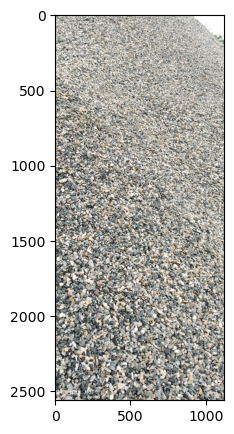

In [19]:
plt.figure(figsize=(7,5))
plt.imshow(tt2, cmap='gray')

In [22]:
%%time
# We're using 25% of all soils for testing and 75% for training
# Next step is to populate the data frame

for soil, soil_path, class_, sd in zip(all_soils, all_soil_path, [0,1,1,2], seed_map):
    train=soil[0:int(len(soil)*0.75)]
    test=soil[int(len(soil)*0.75):]
    print(f"For current soil in class {class_}, we have {len(train)} training data and {len(test)} testing data!")

    print ('Working on Training Set')
    for soil_pic in tqdm(train):
        naive_particle_pic, fourier_pic, color_pic, lab, kept=preprocess_v2(soil_path+soil_pic, blend_x=1, blend_y=0, canny_x=50, canny_y=400,
                                                             alpha=2.5, beta=-1.5, gamma=20, Tlength=5, sigma=2, sharp_scale=1,
                                                                           blur_scale=0)
        #print(naive_particle_pic, soil_path+soil_pic)
        naive_particle_sum=get_pixel_sum_v2(naive_particle_pic, 10)
        #print(type(naive_particle_sum))
        percentiles=get_percentiles_distance(naive_particle_sum, perc_distance=1)
        #print(percentiles)
        color_perc=get_color(color_pic)
        fourier_perc=get_fourier_distribution(fourier_pic)
        fourier_med=get_fourier_radius(fourier_pic, r=20)
        # get color info
        percentiles.extend(color_perc)
        percentiles.extend(fourier_perc)
        plus=[fourier_med, class_, soil_path+soil_pic, lab, kept]
        percentiles.extend(plus)
        #print(len(percentiles))
        working_df_train_batch.loc[len(working_df_train_batch)] = percentiles
    working_df_train_batch['distance']=get_distances(working_df_train_batch.shape[0], seed=sd)
    working_df_train = pd.concat([working_df_train, working_df_train_batch])
    working_df_train_batch=pd.DataFrame(columns=names[:-1])
    
    
    print('\n','======Finished Training set=======', '\n')
    print ('Working on Testing Set')
    for soil_pic_test in tqdm(test):
        naive_particle_pic_test, fourier_pic_test, color_pic_test, lab_test, kept_test=preprocess_v2(soil_path+soil_pic_test, blend_x=1, blend_y=0, canny_x=50, canny_y=400,
                                                             alpha=2.5, beta=-1.5, gamma=20, Tlength=5, sigma=2, sharp_scale=1,
                                                                           blur_scale=0)
        #print(naive_particle_pic, soil_path+soil_pic)
        naive_particle_sum_test=get_pixel_sum_v2(naive_particle_pic_test, 10)
        #print(type(naive_particle_sum))
        percentiles_test=get_percentiles_distance(naive_particle_sum_test, perc_distance=1)
        #print(percentiles)
        color_perc_test=get_color(color_pic_test)
        fourier_perc_test=get_fourier_distribution(fourier_pic_test)
        fourier_med_test=get_fourier_radius(fourier_pic_test, r=20)
        # get color info
        percentiles_test.extend(color_perc_test)
        percentiles_test.extend(fourier_perc_test)
        plus_test=[fourier_med_test, class_, soil_path+soil_pic_test, lab_test, kept_test]
        percentiles_test.extend(plus_test)
        #print(len(percentiles))
        working_df_test_batch.loc[len(working_df_test_batch)] = percentiles_test
    working_df_test_batch['distance']=get_distances(working_df_test_batch.shape[0], seed=sd+1)
    working_df_test = pd.concat([working_df_test, working_df_test_batch])
    working_df_test_batch=pd.DataFrame(columns=names[:-1])
    print('\n')

For current soil in class 0, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [08:24<00:00,  6.72s/it]
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:42<00:00,  6.49s/it]
<timed exec>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [05:48<00:00,  4.64s/it]
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:02<00:00,  4.91s/it]
<timed exec>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 1, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [04:59<00:00,  4.00s/it]
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [01:27<00:00,  3.51s/it]
<timed exec>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 2, we have 75 training data and 25 testing data!
Working on Training Set


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [06:35<00:00,  5.27s/it]
<timed exec>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:36<00:00,  6.26s/it]



CPU times: total: 33min 23s
Wall time: 34min 37s



<timed exec>:56: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


In [26]:
working_df_train.tail(30)

perc_1  perc_2  perc_3  perc_4  perc_5  perc_6  perc_7  perc_8  perc_9  \
45    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
46    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
47    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
48    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
49    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
50    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
51    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
52    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
53    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
54    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
55    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
56    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
57    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
58    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
59    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
60    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
61    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
62    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
63    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
64    0.00     0.0    0.00     0.0     0.0    0.00     0.0     0.0     0.0   
65   11.00    14.0   16.00    18.0    19.0   20.00    20.0    21.0    21.0   
66    8.00    13.0   15.00    16.0    18.0   19.00    20.0    21.0    22.0   
67    9.00    13.0   15.00    17.0    18.0   19.00    20.0    21.0    21.0   
68    8.99    13.0   15.00    17.0    18.0   19.00    20.0    20.0    21.0   
69    9.00    12.0   13.00    15.0    16.0   18.00    19.0    19.0    20.0   
70    4.00     8.0   10.00    13.0    14.0   15.00    16.0    17.0    18.0   
71    6.00    10.0   13.00    15.0    16.0   17.94    18.0    19.0    20.0   
72    6.00     9.0   12.00    14.0    15.0   16.00    17.0    18.0    19.0   
73    3.99     7.0    9.00    12.0    13.0   15.00    16.0    17.0    18.0   
74    4.99     8.0   11.97    13.0    15.0   16.00    17.0    18.0    19.0   

    perc_10  ...  fourier_distribution_70  fourier_distribution_80  \
45      0.0  ...               195.296562               198.348984   
46      0.0  ...               194.966125               198.028839   
47      0.0  ...               195.944351               199.044327   
48      0.0  ...               196.311829               199.321136   
49      0.0  ...               196.529099               199.540680   
50      0.0  ...               197.698059               200.637909   
51      0.0  ...               198.307404               201.260529   
52      0.0  ...               198.533005               201.486328   
53      0.0  ...               199.342598               202.329416   
54      0.0  ...               199.453224               202.473691   
55      0.0  ...               199.614719               202.542746   
56      0.0  ...               197.946538               200.873639   
57      0.0  ...               198.318709               201.284973   
58      0.0  ...               198.149506               201.188965   
59      0.0  ...               198.297363               201.249573   
60      0.0  ...               197.871974               200.869220   
61      0.0  ...               198.477814               201.447739   
62      0.0  ...               199.131306               202.072327   
63      0.0  ...               199.058502               202.038559   
64      0.0  ...               202.041092               205.028690   
65     22.0  ...               209.013721               211.954657   
66     22.0  ...               208.999216    

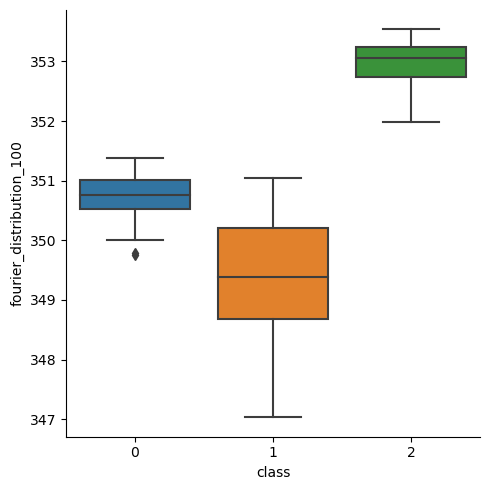

In [32]:
sns.catplot(x='class', y='fourier_median', data=working_df_train, kind='box')

In [64]:
# Casting all object dtypes to number
object_dtype=working_df_test.select_dtypes(include=['object']).columns

for obj in object_dtype:
    if obj!='image_name':
        working_df_train[obj]=working_df_train[obj].astype(float)
        working_df_test[obj]=working_df_test[obj].astype(float)
    

In [60]:
X=working_df_train.drop(['class', 'image_name'], axis=1)
y=working_df_train['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [65]:
working_df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 24
Columns: 128 entries, perc_1 to distance
dtypes: float32(1), float64(126), object(1)
memory usage: 104.5+ KB


In [78]:
dec_tree = RandomForestClassifier(random_state=88)

In [79]:
dec_tree.fit(X, y)

RandomForestClassifier(random_state=88)

In [80]:
pred=dec_tree.predict(working_df_test.drop(['class', 'image_name'], axis=1))

In [81]:
f1_score(working_df_test[['class']], pred, average='macro')

1.0

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125],
 [Text(0, 0, 'perc_1'),
  Text(1, 0, 'perc_2'),
  Text(2, 0, 'perc_3'),
  Text(3, 0, 'perc_4'),
  Text(4, 0, 'perc_5'),
  Text(5, 0, 'perc_6'),
  Text(6, 0, 'perc_7'),
  Text(7, 0, 'perc_8'),
  Text(8, 0, 'perc_9'),
  Text(9, 0

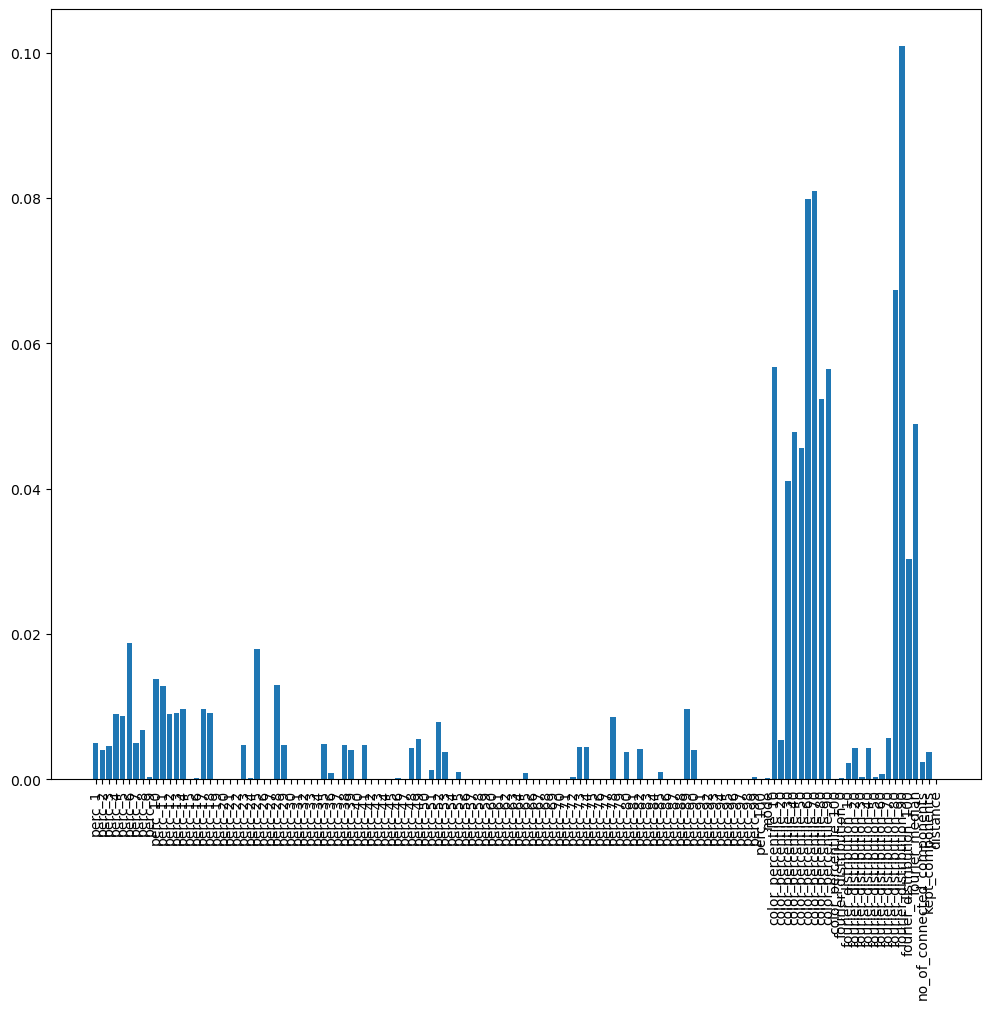

In [82]:
plt.figure(figsize=(12,10))
plt.bar(X.columns,dec_tree.feature_importances_)
plt.xticks(rotation=90)

## ADABOOST PARAMETER TUNING

In [127]:
ada_clf = AdaBoostClassifier(random_state=76)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': list(range(50, 1000, 100)),  # Number of weak learners
    'learning_rate': [0.001, 0.01, 0.03, 0.3, 0.7, 1]  # Learning rate
}

f1_scorer = make_scorer(f1_score, average='macro')

# Perform grid search cross-validation
grid_search = GridSearchCV(ada_clf, param_grid, cv=4, verbose=5, scoring=f1_scorer)
grid_search.fit(X, y)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Fitting 4 folds for each of 60 candidates, totalling 240 fits
[CV 1/4] END learning_rate=0.001, n_estimators=50;, score=0.296 total time=   0.1s
[CV 2/4] END learning_rate=0.001, n_estimators=50;, score=0.568 total time=   0.1s
[CV 3/4] END learning_rate=0.001, n_estimators=50;, score=0.572 total time=   0.2s
[CV 4/4] END learning_rate=0.001, n_estimators=50;, score=0.572 total time=   0.1s
[CV 1/4] END learning_rate=0.001, n_estimators=150;, score=0.296 total time=   0.5s
[CV 2/4] END learning_rate=0.001, n_estimators=150;, score=0.570 total time=   0.5s
[CV 3/4] END learning_rate=0.001, n_estimators=150;, score=0.572 total time=   0.5s
[CV 4/4] END learning_rate=0.001, n_estimators=150;, score=0.572 total time=   0.4s
[CV 1/4] END learning_rate=0.001, n_estimators=250;, score=0.296 total time=   0.8s
[CV 2/4] END learning_rate=0.001, n_estimators=250;, score=0.570 total time=   0.8s
[CV 3/4] END learning_rate=0.001, n_estimators=250;, score=0.572 total time=   0.9s
[CV 4/4] END learn

[CV 3/4] END learning_rate=0.03, n_estimators=450;, score=0.142 total time=   2.4s
[CV 4/4] END learning_rate=0.03, n_estimators=450;, score=0.231 total time=   2.5s
[CV 1/4] END learning_rate=0.03, n_estimators=550;, score=0.325 total time=   2.5s
[CV 2/4] END learning_rate=0.03, n_estimators=550;, score=0.753 total time=   2.6s
[CV 3/4] END learning_rate=0.03, n_estimators=550;, score=0.154 total time=   3.1s
[CV 4/4] END learning_rate=0.03, n_estimators=550;, score=0.225 total time=   2.6s
[CV 1/4] END learning_rate=0.03, n_estimators=650;, score=0.328 total time=   3.7s
[CV 2/4] END learning_rate=0.03, n_estimators=650;, score=0.622 total time=   3.3s
[CV 3/4] END learning_rate=0.03, n_estimators=650;, score=0.172 total time=   3.3s
[CV 4/4] END learning_rate=0.03, n_estimators=650;, score=0.229 total time=   3.6s
[CV 1/4] END learning_rate=0.03, n_estimators=750;, score=0.309 total time=   4.5s
[CV 2/4] END learning_rate=0.03, n_estimators=750;, score=0.582 total time=   4.4s
[CV 

[CV 3/4] END learning_rate=0.7, n_estimators=950;, score=0.553 total time=   7.5s
[CV 4/4] END learning_rate=0.7, n_estimators=950;, score=0.571 total time=   4.5s
[CV 1/4] END ..learning_rate=1, n_estimators=50;, score=0.297 total time=   0.1s
[CV 2/4] END ..learning_rate=1, n_estimators=50;, score=0.659 total time=   0.1s
[CV 3/4] END ..learning_rate=1, n_estimators=50;, score=0.583 total time=   0.1s
[CV 4/4] END ..learning_rate=1, n_estimators=50;, score=0.554 total time=   0.1s
[CV 1/4] END .learning_rate=1, n_estimators=150;, score=0.296 total time=   0.6s
[CV 2/4] END .learning_rate=1, n_estimators=150;, score=0.659 total time=   0.7s
[CV 3/4] END .learning_rate=1, n_estimators=150;, score=0.663 total time=   0.7s
[CV 4/4] END .learning_rate=1, n_estimators=150;, score=0.579 total time=   0.6s
[CV 1/4] END .learning_rate=1, n_estimators=250;, score=0.296 total time=   0.9s
[CV 2/4] END .learning_rate=1, n_estimators=250;, score=0.659 total time=   1.1s
[CV 3/4] END .learning_rat

In [73]:
Ada = AdaBoostClassifier(learning_rate=1, n_estimators=650, random_state=76)

In [74]:
Ada.fit(X, y)

AdaBoostClassifier(learning_rate=1, n_estimators=650, random_state=76)

In [75]:
real_pred = Ada.predict(working_df_test.drop('class', axis=1))
real_true = working_df_test[['class']]

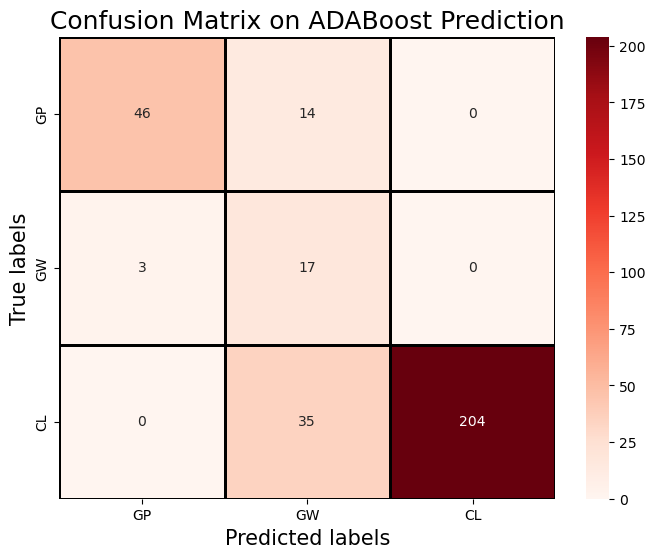

In [78]:
# Compute confusion matrix
cm = confusion_matrix(real_pred, real_true)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Reds', fmt='g', xticklabels=['GP', 'GW', 'CL'], 
            yticklabels=['GP', 'GW', 'CL'], linewidths=2, linecolor='k')
plt.xlabel('Predicted labels', fontsize=15)
plt.ylabel('True labels', fontsize=15)
plt.title('Confusion Matrix on ADABoost Prediction', fontsize=18)
plt.savefig('ada_matrix_correct_class.jpg', dpi=2000, bbox_inches='tight')
plt.show()


## Main Parameter Tuning starts here

In [13]:
%%time
# MASTER PARAM LIST
# Parameters to test

# These kernel shapes have to be multiples of 50
kernel_shapes = [10,20,35]

# These blending ratios are for hist equa and image sharpening
blending_ratios = [(0, 1), (0.1, 0.9), (0.2, 0.8), (0.3, 0.7), (0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7,0.3), (0.8,0.2), (0.9,0.1),
            (1, 0)]
canny_x=list(range(100,301,100))
canny_y=list(range(200,801,100))

alphas=[1.5,2.5,3.5]
betas=[-0.3,-0.5,-1.5]
gammas=list(range(10,60,10))
sigmas=list(range(2,10,2))
Tlengths=list(range(5,50,10))
rads=list(range(10,101,10))

combine_canny=[]
for a in canny_x:
    for b in canny_y:
        combine_canny.append((a,b))

all_parameters= list(product(kernel_shapes, blending_ratios, combine_canny, alphas, betas, gammas, sigmas, Tlengths, rads))

CPU times: total: 1.3 s
Wall time: 1.31 s


In [14]:
len(all_parameters), all_parameters[0]

(6237000, (10, (0, 1), (100, 200), 1.5, -0.3, 10, 2, 5, 10))

In [15]:
# Creating same dir in Validation dir change Test to Train afterwards to make train and test dirs
#for dir_ in os.listdir('test_data/Useful/Test'):
#    os.mkdir('test_data/Useful/Validation/'+dir_)

In [5]:
soils={"1 inch at 1ft":["close", 0, 28], "1 inch at 2ft":["far", 0, 28], "1.5 inches at 1 ft":["close", 1, 30], 
       "1.5 inches at 2ft":["far", 1, 30], "2 inches at 1ft":["close", 0, 32], "2 inches at 2ft":["far", 0, 32], 
       "Close-Hard-Core":["close", 1, 34], "Far-Hard-Core":["far", 1, 34], "Half inch at 1 ft":["close", 1, 36], 
       "Nsk-Gravel-Big-Close":["close", 1, 38], "Nsk-Gravel-Small-Close":["close", 1, 40], 
       "Nsk-White-Sand-Close":["close", 6, 42], "Red Sand":["close", 4, 44], "rice-at-1-ft":["close", 0, 46], 
       "rice-at-2-ft":["far", 0, 46], "sharp sand at 1ft":["close", 3, 48], "sharp sand at 2ft":["far", 3, 48], 
       "Stone Dust at 1 ft":["close", 2, 50], "Three eight at 1ft":["close", 0, 50], 
       "Three Quarter at 1 ft":["close", 1, 52]}

In [6]:
# Importing images

soil_path='test_data/Useful/Validation/'

unique_classes=['GP','GW','GM','SP','SM', 'SW'] # [0-6]

exempt_keys=["Close-Hard-Core", "Far-Hard-Core", "Nsk-Gravel-Big-Close", "Nsk-Gravel-Small-Close"]

new = ["params","perc_distance", "precision_micro_train", "precision_macro_train", "precision_weighted_train",
        "recall_micro_train", "recall_macro_train", "recall_weighted_train", "f1_micro_train", "f1_macro_train",
        "f1_weighted_train", "accuracy_train", "precision_micro_test", "precision_macro_test", "precision_weighted_test",
        "recall_micro_test", "recall_macro_test", "recall_weighted_test", "f1_micro_test", "f1_macro_test",
        "f1_weighted_test", "accuracy_test"]

In [11]:
# Step 3: Create a DataFrame to store the matrix and metadata
tr_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]
}

te_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]
}

cols=['filename','image_matrix','shape']

df_train = pd.DataFrame(columns=cols)
df_test = pd.DataFrame(columns=cols)

In [12]:
for soil_key in soils.keys():
    print('========Started for soil ', soil_key, '===========')
    soil=sorted(os.listdir(soil_path+soil_key))
    train=soil[0:int(len(soil)*0.70)]#[:10]
    test=soil[int(len(soil)*0.70):]
    
    for str_ in tqdm(train):
        image_path=soil_path+soil_key+'/'+str_
        img=cv.imread(image_path)
        col_img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
        colors=get_color(col_img, normalize=True)
        col_img_gray=cv.cvtColor(col_img, cv.COLOR_RGB2GRAY)
        col_img_gray=crop_to_square(col_img_gray)
        
        # Resizing image
        gray_resized = cv.resize(col_img_gray, (500,500))

        image_matrix=gray_resized.flatten()
        #print(len(image_matrix))
        # Compress the image data
        #compressed_image = zlib.compress(image_matrix.tobytes())
        #encoded_data = base64.b64encode(compressed_image).decode('utf-8')
        #print(encoded_data)
        #sparse_matrix = csc_matrix(image_matrix)
        #save_npz(str_+'.npz', sparse_matrix)
        #print(encoded_data)
        #string=','.join(map(str,image_matrix))
        #print(string)
        
        col_img_shape=col_img.shape
        tr_data['filename'].append(image_path)
        tr_data['image_matrix'].append(image_matrix.tolist())
        tr_data['shape'].append(col_img_shape)
        tr_data['image_dir'].append(soil_key)
        tr_data['color_percs'].append(colors)
    df_train = pd.DataFrame(tr_data)
    #display(df_train.head())
    #df_train.to_hdf('image_data.h5', key='data', mode='w', complevel=9, complib='zlib')
    df_train.to_parquet(soil_key+'_train.parquet')
    tr_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]}
    
    for ste_ in tqdm(test):
        image_path=soil_path+soil_key+'/'+ste_
        img=cv.imread(image_path)
        col_img=cv.cvtColor(img, cv.COLOR_BGR2RGB)
        colors=get_color(col_img, normalize=True)
        col_img_gray=cv.cvtColor(col_img, cv.COLOR_RGB2GRAY)
        col_img_gray=crop_to_square(col_img_gray)
        
        # Resizing image
        gray_resized = cv.resize(col_img_gray, (500,500))

        image_matrix=gray_resized.flatten()
        col_img_shape=col_img.shape
        te_data['filename'].append(image_path)
        te_data['image_matrix'].append(image_matrix.tolist())
        te_data['shape'].append(col_img_shape)
        te_data['image_dir'].append(soil_key)
        te_data['color_percs'].append(colors)
    df_test = pd.DataFrame(te_data)
    df_test.to_parquet(soil_key+'_test.parquet')
    te_data = {
    'filename': [],
    'image_matrix': [],  # Convert NumPy array to a list for storage
    'shape': [], # Store the shape to reconstruct later
    'image_dir': [],
    'color_percs':[]}
    
    print('=========Ending for soil ', soil_key, '===========')

========Started for soil  1 inch at 1ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:06<00:00,  2.80s/it]


=========Ending for soil  1 inch at 1ft ===========
========Started for soil  1 inch at 2ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:16<00:00,  3.02s/it]


=========Ending for soil  1 inch at 2ft ===========
========Started for soil  1.5 inches at 1 ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:14<00:00,  3.00s/it]


=========Ending for soil  1.5 inches at 1 ft ===========
========Started for soil  1.5 inches at 2ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:05<00:00,  2.79s/it]


=========Ending for soil  1.5 inches at 2ft ===========
========Started for soil  2 inches at 1ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:28<00:00,  3.30s/it]


=========Ending for soil  2 inches at 1ft ===========
========Started for soil  2 inches at 2ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:17<00:00,  3.06s/it]


=========Ending for soil  2 inches at 2ft ===========
========Started for soil  Close-Hard-Core ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:22<00:00,  1.34it/s]


=========Ending for soil  Close-Hard-Core ===========
========Started for soil  Far-Hard-Core ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 29/29 [00:07<00:00,  3.76it/s]


=========Ending for soil  Far-Hard-Core ===========
========Started for soil  Half inch at 1 ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:40<00:00,  1.10it/s]


=========Ending for soil  Half inch at 1 ft ===========
========Started for soil  Nsk-Gravel-Big-Close ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:45<00:00,  3.51s/it]


=========Ending for soil  Nsk-Gravel-Big-Close ===========
========Started for soil  Nsk-Gravel-Small-Close ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:53<00:00,  3.79s/it]


=========Ending for soil  Nsk-Gravel-Small-Close ===========
========Started for soil  Nsk-White-Sand-Close ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:52<00:00,  3.84s/it]


=========Ending for soil  Nsk-White-Sand-Close ===========
========Started for soil  Red Sand ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:53<00:00,  3.55s/it]


=========Ending for soil  Red Sand ===========
========Started for soil  rice-at-1-ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:58<00:00,  2.62s/it]


=========Ending for soil  rice-at-1-ft ===========
========Started for soil  rice-at-2-ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [01:58<00:00,  2.63s/it]


=========Ending for soil  rice-at-2-ft ===========
========Started for soil  sharp sand at 1ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:12<00:00,  2.94s/it]


=========Ending for soil  sharp sand at 1ft ===========
========Started for soil  sharp sand at 2ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:18<00:00,  3.08s/it]


=========Ending for soil  sharp sand at 2ft ===========
========Started for soil  Stone Dust at 1 ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:33<00:00,  1.35it/s]


=========Ending for soil  Stone Dust at 1 ft ===========
========Started for soil  Three eight at 1ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:41<00:00,  1.09it/s]


=========Ending for soil  Three eight at 1ft ===========
========Started for soil  Three Quarter at 1 ft ===========


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:41<00:00,  1.10it/s]


=========Ending for soil  Three Quarter at 1 ft ===========


In [ ]:
'''
Testing save format file size
encodedh5=30mb 5s save time
normalh5=50mb 5s save time
encodedcsvzip= 
normalcsvzip= 30mb >30s save time
normalpklcsv= 50mb
parquet=20mb'''

In [13]:
df=pd.read_parquet("Red Sand_train.parquet")

In [14]:
df.head()

filename  \
0  test_data/Useful/Validation/Red Sand/IMG_6941....   
1  test_data/Useful/Validation/Red Sand/IMG_6942....   
2  test_data/Useful/Validation/Red Sand/IMG_6943....   
3  test_data/Useful/Validation/Red Sand/IMG_6944....   
4  test_data/Useful/Validation/Red Sand/IMG_6945....   

                                        image_matrix            shape  \
0  [168, 142, 144, 160, 165, 133, 149, 50, 113, 1...  [3024, 3024, 3]   
1  [120, 148, 84, 83, 75, 109, 142, 117, 89, 22, ...  [3024, 3024, 3]   
2  [58, 18, 56, 127, 156, 140, 94, 124, 122, 55, ...  [3024, 3024, 3]   
3  [21, 146, 124, 117, 29, 59, 37, 33, 66, 138, 1...  [3024, 3024, 3]   
4  [69, 72, 93, 159, 166, 112, 151, 166, 169, 170...  [3024, 3024, 3]   

  image_dir                                        color_percs  
0  Red Sand  [1000.3960784375668, 1000.4784313738346, 1000....  
1  Red Sand  [1000.3960784375668, 1000.4823529422283, 1000....  
2  Red Sand  [1000.3960784375668, 1000.4745098054409, 1000....  
3  Red Sand  [1000.3725490272045, 1000.4509803950787, 1000....  
4  Red Sand  [1000.3372549116611, 1000.4039215743542, 1000....

In [15]:
retrieved_encoded = df['image_matrix'][0]
retrieved_compressed = base64.b64decode(retrieved_encoded)
#print(retrieved_compressed)
retrieved_flattened = np.frombuffer(zlib.decompress(retrieved_compressed), dtype=np.uint8)
retrieved_image = retrieved_flattened.reshape((500, 500))

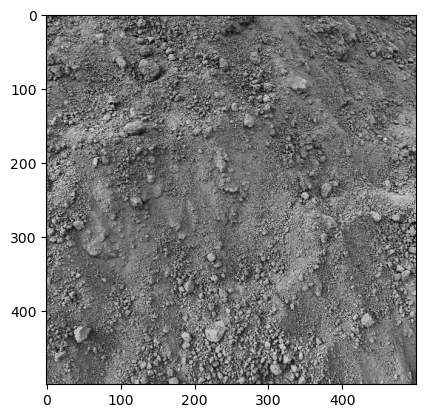

In [16]:
plt.imshow(df['image_matrix'][2].reshape((500,500)), cmap='gray')

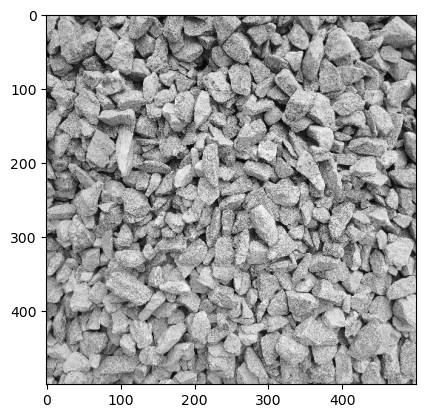

In [56]:
plt.imshow(retrieved_image, cmap='gray')

In [31]:
%%time
metrics_df_columns=new
metrics_df=pd.DataFrame(columns=metrics_df_columns)

for params in all_parameters[:]:
    start_time = dt.datetime.now()
    start_time_conv = start_time.strftime("%Y-%m-%d %H:%M:%S")

    expected_end_time = start_time+dt.timedelta(minutes=34)
    expected_end_time_conv = expected_end_time.strftime("%Y-%m-%d %H:%M:%S")
    print('=====Started process for', params, 'set =====')
    print('Iteration started at:', start_time_conv, 'expected end time is:', expected_end_time_conv)
    
    #Unpacking tuple
    kern, blend_rt, canny_combo, alph, bet, gam, sig, tl, rd = params
    
    working_df_train = pd.DataFrame(columns=names)
    working_df_test = pd.DataFrame(columns=names)
    
    working_df_train_batch=pd.DataFrame(columns=names[:-1])
    working_df_test_batch=pd.DataFrame(columns=names[:-1])

    for soil_key in soils.keys():
        soil=sorted(os.listdir(soil_path+soil_key)) #[:10]
        soil_path_new=soil_path+soil_key+'/'
        if soil_key in exempt_keys:
            test=soil
            train=[]
            #pass
        else:
            train=soil[0:int(len(soil)*0.70)]
            test=soil[int(len(soil)*0.70):]
        dist_=soils[soil_key][0]
        class_=soils[soil_key][1]
        sd=soils[soil_key][2]
        print(f"For current soil in class {class_}, we have {len(train)} training data and {len(test)} testing data!")

        print ('Working on Training Set')
        tic = time()
        for soil_pic in train:

            naive_particle_pic, fourier_pic, color_pic, lab, kept=preprocess_v2(soil_path_new+soil_pic, blend_x=blend_rt[0],\
                                blend_y=blend_rt[1], canny_x=canny_combo[0], canny_y=canny_combo[1], alpha=alph, \
                                beta=bet, gamma=gam, Tlength=tl, sigma=sig, sharp_scale=blend_rt[0], blur_scale=blend_rt[1])
            #print(naive_particle_pic, soil_path+soil_pic)
            naive_particle_sum=get_pixel_sum_v2(naive_particle_pic, kern)
            #print(type(naive_particle_sum))
            percentiles=get_percentiles_distance(naive_particle_sum, perc_distance=1)
            #print(percentiles)
            color_perc=get_color(color_pic)
            fourier_perc=get_fourier_distribution(fourier_pic)
            fourier_med=get_fourier_radius(fourier_pic, r=rd)
            # get color info
            percentiles.extend(color_perc)
            percentiles.extend(fourier_perc)
            plus=[fourier_med, class_, soil_path_new+soil_pic, lab, kept]
            percentiles.extend(plus)
            #print(len(percentiles))
            working_df_train_batch.loc[len(working_df_train_batch)] = percentiles
        working_df_train_batch['distance']=get_distances(working_df_train_batch.shape[0], seed=sd, dist=dist_)
        working_df_train = pd.concat([working_df_train, working_df_train_batch])
        working_df_train_batch=pd.DataFrame(columns=names[:-1])
        toc = time()
        print(f'Time elapsed: {(toc-tic)/60:0.2f} minutes\n')
        

        print('\n','======Finished Training set=======', '\n')
        print ('Working on Testing Set')
        for soil_pic_test in tqdm(test):
            #print(soil_path_new+soil_pic_test)
            naive_particle_pic_test, fourier_pic_test, color_pic_test, lab_test, kept_test=preprocess_v2(soil_path_new+soil_pic_test,
                                                                                                         blend_x=blend_rt[0],\
                                blend_y=blend_rt[1], canny_x=canny_combo[0], canny_y=canny_combo[1], alpha=alph, \
                                beta=bet, gamma=gam, Tlength=tl, sigma=sig, sharp_scale=blend_rt[0], blur_scale=blend_rt[1])
            #print(naive_particle_pic, soil_path+soil_pic)
            naive_particle_sum_test=get_pixel_sum_v2(naive_particle_pic_test, kern)
            #print(type(naive_particle_sum))
            percentiles_test=get_percentiles_distance(naive_particle_sum_test, perc_distance=1)
            #print(percentiles)
            color_perc_test=get_color(color_pic_test)
            fourier_perc_test=get_fourier_distribution(fourier_pic_test)
            fourier_med_test=get_fourier_radius(fourier_pic_test, r=rd)
            # get color info
            percentiles_test.extend(color_perc_test)
            percentiles_test.extend(fourier_perc_test)
            plus_test=[fourier_med_test, class_, soil_path_new+soil_pic_test, lab_test, kept_test]
            percentiles_test.extend(plus_test)
            #print(len(percentiles))
            working_df_test_batch.loc[len(working_df_test_batch)] = percentiles_test
        working_df_test_batch['distance']=get_distances(working_df_test_batch.shape[0], seed=sd+1, dist=dist_)
        working_df_test = pd.concat([working_df_test, working_df_test_batch])
        working_df_test_batch=pd.DataFrame(columns=names[:-1])
        print('\n')
        
    object_dtype=working_df_test.select_dtypes(include=['object']).columns
    for obj in object_dtype:
        if obj!='image_name':
            working_df_train[obj]=working_df_train[obj].astype(float)
            working_df_test[obj]=working_df_test[obj].astype(float)

    dec_tree = DecisionTreeClassifier(random_state=88, max_depth=25)
    dec_tree.fit(working_df_train.drop(['class', 'image_name'], axis=1), working_df_train[['class']])
    print(working_df_train.shape, working_df_test.shape)
    print('Saving Dfs')
    working_df_train.to_csv('train_df'+str(params)+'.csv')
    working_df_test.to_csv('test_df'+str(params)+'.csv')
    
    y_pred_tr=dec_tree.predict(working_df_train.drop(['class', 'image_name'], axis=1))
    y_pred_te=dec_tree.predict(working_df_test.drop(['class', 'image_name'], axis=1))

    precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train, recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train=get_metrics(working_df_train[['class']],y_pred_tr)
    precision_micro_test, precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test=get_metrics(working_df_test[['class']],y_pred_te)
    metrics_df.loc[len(metrics_df)] = [params, perc_distance, precision_micro_train, precision_macro_train,precision_weighted_train,recall_micro_train,recall_macro_train,recall_weighted_train,f1_micro_train,f1_macro_train,f1_weighted_train, accuracy_train, precision_micro_test,precision_macro_test,precision_weighted_test,recall_micro_test,recall_macro_test,recall_weighted_test,f1_micro_test,f1_macro_test,f1_weighted_test, accuracy_test]
    if metrics_df.shape[0] in list(range(10, 20001, 10)):
        metrics_df.to_csv('metrics'+str(metrics_df.shape[0])+'.csv')

=====Started process for (10, (0, 1), (100, 200), 1.5, -0.3, 10, 2, 5, 10) set =====
Iteration started at: 2024-11-20 08:43:13 expected end time is: 2024-11-20 09:17:13
For current soil in class 0, we have 105 training data and 45 testing data!
Working on Training Set


<timed exec>:59: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


Time elapsed: 5.42 minutes


 ======Finished Training set======= 

Working on Testing Set


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [02:22<00:00,  3.16s/it]
<timed exec>:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`




For current soil in class 0, we have 105 training data and 45 testing data!
Working on Training Set



KeyboardInterrupt



<Axes: xlabel='class', ylabel='color_percentile_10'>

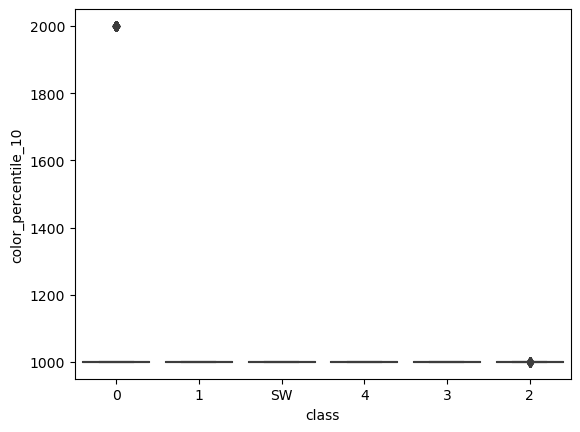

In [26]:
#5mins 25s
sns.boxplot(x='class', y='color_percentile_10', data =working_df_train)

In [22]:
working_df_train[]

perc_1  perc_2  perc_3  perc_4  perc_5  perc_6  perc_7  perc_8  perc_9  \
0       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.00   
1       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.00   
2       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.00   
3       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.00   
4       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0    0.00   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
100     0.0     0.0     0.0     0.0     0.0     1.0     2.0     3.0    3.00   
101     0.0     0.0     0.0     0.0     1.0     2.0     3.0     3.0    4.00   
102     0.0     0.0     0.0     0.0     0.0     1.0     2.0     3.0    3.91   
103     0.0     0.0     0.0     0.0     0.0     1.0     1.0     2.0    3.00   
104     0.0     0.0     0.0     0.0     0.0     1.0     1.0     2.0    3.00   

     perc_10  ...  fourier_distribution_70  fourier_distribution_80  \
0        0.0  ...               149.941956               161.793228   
1        0.0  ...               149.815730               161.919614   
2        0.0  ...               149.968750               162.111664   
3        0.0  ...               150.018391               161.770538   
4        0.0  ...               150.063995               161.126617   
..       ...  ...                      ...                      ...   
100      4.0  ...               151.643013               162.040582   
101      4.0  ...               151.823264               162.742438   
102      4.0  ...               151.372295               161.641449   
103      3.9  ...               152.388605               163.152182   
104      3.9  ...               152.388605               163.152182   

     fourier_distribution_90  fourier_distribution_100  fourier_median  class  \
0                 179.852905                345.655365      252.340485      0   
1                 180.061356                345.649963      252.397385      0   
2                 180.060638                345.653107      252.757721      0   
3                 180.007768                345.655701      252.634399      0   
4                 180.075287                345.653015      252.465958      0   
..                       ...                       ...             ...    ...   
100               183.112411                345.578766      247.409286      1   
101               183.536652                345.581360      247.125031      1   
102               183.019196                345.585663      247.414642      1   
103               183.457458                345.566345      247.749802      1   
104               183.457458                345.566345      247.749802      1   

                                            image_name  \
0    test_data/Useful/Validation/1 inch at 1ft/2024...   
1    test_data/Useful/Validation/1 inch at 1ft/2024...   
2    test_data/Useful/Validation/1 inch at 1ft/2024...   
3    test_data/Useful/Validation/1 inch at 1ft/2024...   
4    test_data/Useful/Validation/1 inch at 1ft/2024...   
..                                                 ...   
100  test_data/Useful/Validation/Three Quarter at 1...   
101  test_data/Useful/Validation/Three Quarter at 1...   
102  test_data/Useful/Validation/Three Quarter at 1...   
103  test_data/Useful/Validation/Three Quarter at 1...   
104  test_data/Useful/Validation/Three Quarter at 1...   

     no_of_connected_components  kept_components   distance  
0                           577              566  31.338997  
1                           559              546  35.007360  
2                           564              556  29.207160  
3                           586              577  27.096495  
4                           597              578  30.177565  
..                          ...              ...        ...  
100                         669              655  31.333504  
101                         698      

## Generating Reports

In [ ]:
def class_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict= True)
    report_df = pd.DataFrame(report).transpose()
    n = [range(4)]
    n.append('accuracy')
    n.append('macro avg')
    n.append('weighted avg')
    report_df.index = n
    return report_df

In [36]:
def get_cnn_plot(mod_history_var, metric='f1_metric'):
  ## Plotting the loss
  train_ = history.history[metric]
  val_ = history.history['val_'+metric]
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8,6))
  plt.xticks(range(1, len(loss) + 1, 5))
  plt.plot(epochs, train_, 'y', label='Training')
  plt.plot(epochs, val_, 'r', label='Validation')

  plt.xlabel('Epochs')
  plt.ylabel(metric)
  plt.legend()
  plt.grid()
  #plt.savefig('loss.jpg', dpi = 300, bbox_inches='tight')
  plt.show()


## CNN Functions

In [7]:
def CNN_preprocess(image_path):
    image = cv.imread(image_path)

    # Converting to RGB
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image=tf.cast(image, tf.float32)

    # Resizing image
    resized_im = tf.image.resize(image, (224,224))
    resized_im/=255

    return resized_im.numpy()

In [8]:
def preprocess_cnn_pred(pred):
  all_ = []
  for a in pred:
    a_lst= a.tolist()
    max_=max(a_lst)
    ind = a_lst.index(max_)
    all_.append(ind)
  return all_


In [9]:
def f1_metric(y_true, y_pred):
  y_pred=preprocess_cnn_pred(y_pred)
  f1 = f1_score(y_true, y_pred, average='macro')
  return f1

In [44]:
def CNN_model_fit(learning_rate=0.001):
  # Training the Neural Net
  image_size = 224

  url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
  feature_extract = hub.KerasLayer(url, input_shape = (image_size, image_size, 3))
  feature_extract.trainable = False

  mod = tf.keras.Sequential([
      feature_extract,
      tf.keras.layers.Dense(3, activation = 'softmax')
  ])
  learning_rate = learning_rate
  optim = tf.keras.optimizers.Adam(learning_rate)

  mod.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy', f1_metric])

  return mod


# Using the Neural Network

In [10]:
# Training the Neural Net
image_size = 224

url = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
feature_extract = hub.KerasLayer(url, input_shape = (image_size, image_size, 3))
feature_extract.trainable = False

model = tf.keras.Sequential([
    feature_extract,
    tf.keras.layers.Dense(3, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2261827 (8.63 MB)
Trainable params: 3843 (15.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


## Setting the Learning rate, metrics to track, etc.

In [11]:
learning_rate = 0.001
optim = tf.keras.optimizers.Adam(learning_rate)

model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy', f1_metric])

## Necessary Callbacks

In [12]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Saving best model
save_best = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor = 'val_loss',
                                              save_best_only = True)

In [13]:
%%time
cnn_train_data_list = []
cnn_test_data_list = []

train_target = []
test_target = []

for soil, soil_path, class_ in zip(all_soils, all_soil_path, [0,1,2,2]):
    train=soil[0:int(len(soil)*0.75)]
    test=soil[int(len(soil)*0.75):]

    for tr_pic in tqdm(train):
        cnn_train_data_list.append(CNN_preprocess(soil_path+tr_pic))
        train_target.append(class_)
    for te_pic in tqdm(test):
        cnn_test_data_list.append(CNN_preprocess(soil_path+te_pic))
        test_target.append(class_)

cnn_train_data = np.array(cnn_train_data_list)
cnn_test_data = np.array(cnn_test_data_list)

train_target_arr =np.array(train_target)
train_target_arr.shape

100%|██████████| 25/25 [00:28<00:00,  1.13s/it]


CPU times: user 1min 50s, sys: 33.9 s, total: 2min 24s
Wall time: 6min 59s


In [14]:
cnn_train_data.shape, train_target_arr.shape

(300, 224, 224, 3)

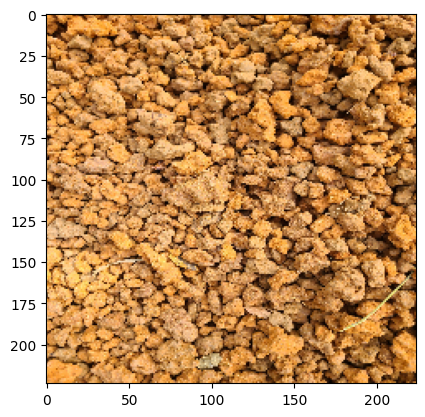

In [18]:
# Displaying one image
plt.imshow(cnn_train_data[0,:,:,:])

In [25]:

# fiting the model
epochs = 2
history = model.fit(x=cnn_train_data,y=train_target_arr,
                       epochs = epochs,
                       validation_split = 0.15,
                       callbacks = [early_stopping, save_best])

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/2
8/8 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 8s 1s/step - loss: 0.2820 - accuracy: 0.8941 - f1_metric: 0.8808 - val_loss: 0.0204 - val_accuracy: 1.0000 - val_f1_metric: 1.0000
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 9s 1s/step - loss: 0.2242 - accuracy: 0.9373 - f1_metric: 0.9214 - val_loss: 0.0135 - val_accuracy: 1.0000 - val_f1_metric: 1.0000


In [26]:
pred = model.predict(cnn_test_data)
pred_conv = preprocess_cnn_pred(pred)

1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 43ms/step


In [28]:
get_metrics(test_target, pred_conv)

(0.93,
 0.9166666666666666,
 0.9375,
 0.93,
 0.9066666666666666,
 0.93,
 0.93,
 0.9057239057239057,
 0.9292929292929293,
 0.93)

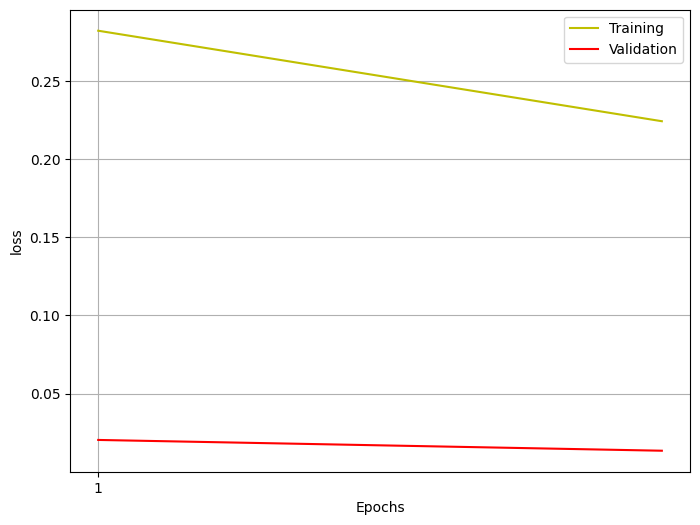

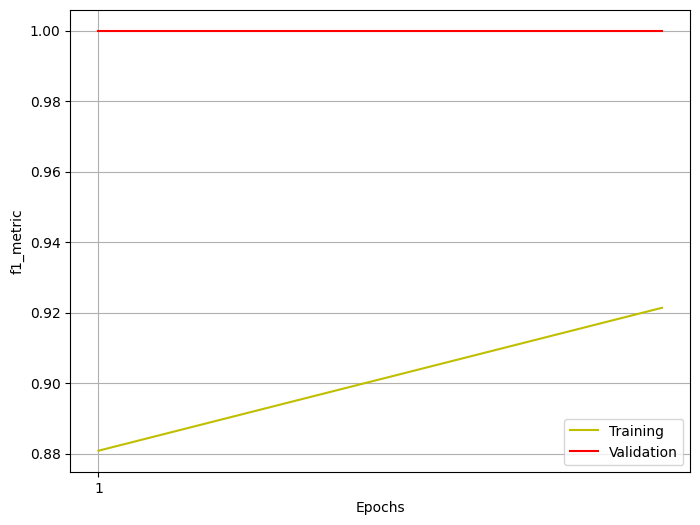

In [37]:
# Loss Plot
get_cnn_plot(history, metric='loss')

# f1_metric plot
get_cnn_plot(history, metric='f1_metric')

## Automated Training and Testing

In [43]:
# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10)

# Saving best model
save_best = tf.keras.callbacks.ModelCheckpoint("./best_model.h5", monitor = 'val_loss',
                                              save_best_only = True)

In [45]:
model_ = CNN_model_fit(learning_rate=0.001)

hist_ = model_.fit(x=cnn_train_data,y=train_target_arr,epochs = 2,validation_split = 0.2,callbacks = [early_stopping, save_best])

Epoch 1/2


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


8/8 [==============================] - ETA: 0s - loss: 1.4000 - accuracy: 0.3083 - f1_metric: 0.2492

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 14s 1s/step - loss: 1.4000 - accuracy: 0.3083 - f1_metric: 0.2492 - val_loss: 0.4789 - val_accuracy: 0.9667 - val_f1_metric: 0.4915
Epoch 2/2
8/8 [==============================] - ETA: 0s - loss: 0.7053 - accuracy: 0.7042 - f1_metric: 0.6536

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 9s 1s/step - loss: 0.7053 - accuracy: 0.7042 - f1_metric: 0.6536 - val_loss: 0.1195 - val_accuracy: 1.0000 - val_f1_metric: 1.0000


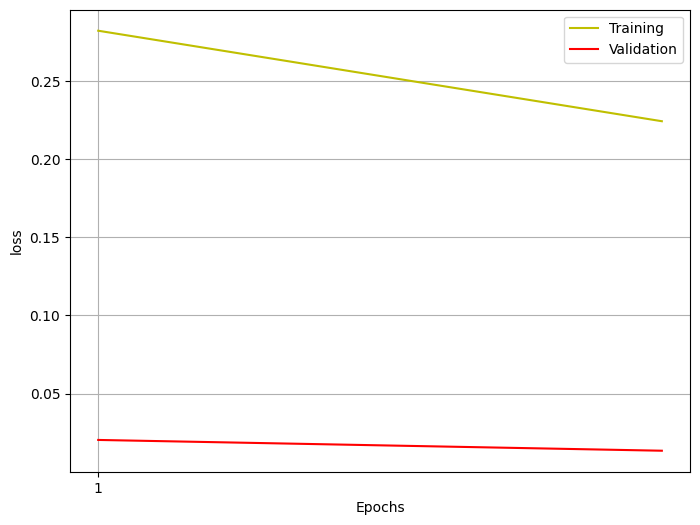

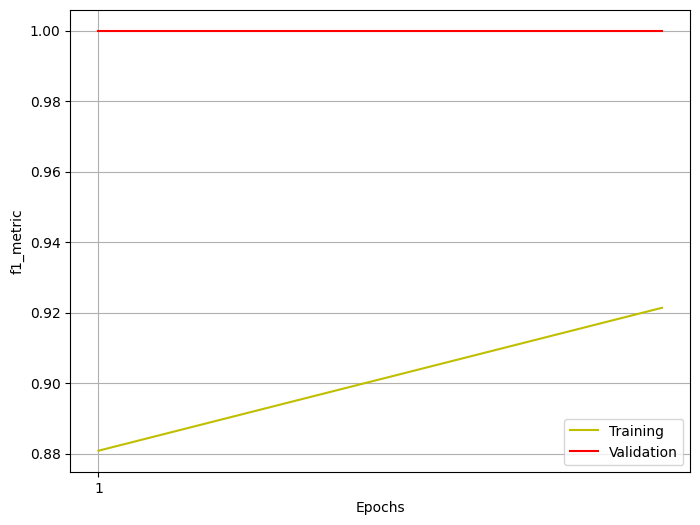

In [46]:
# Loss Plot
get_cnn_plot(hist_, metric='loss')

# f1_metric plot
get_cnn_plot(hist_, metric='f1_metric')

In [47]:
pred1 = model_.predict(cnn_test_data)
pred_conv1 = preprocess_cnn_pred(pred1)

1/4 [======>.......................] - ETA: 0s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 0s 50ms/step


In [48]:
get_metrics(test_target, pred_conv1)

(0.87,
 0.8402777777777778,
 0.8802083333333335,
 0.87,
 0.8266666666666667,
 0.87,
 0.87,
 0.8232014143886849,
 0.8674010607915136,
 0.87)

## Results Analysis
1. Box Plot showing distribution of f1_macro, precision_macro and recall_macro scores. So three plots with just kernel on the xaxis.
2. CDF on just Kernel. This shows the general performance of the kernel like if it's just oene kernel having a high value a box plot might not show that but the cdf will show as just the 100th percentile will show that high value.
3. Blending distribution on a kernel level, x = blending, hue by kernel or column by kernel, any one.
4. I'm still thinking of a way to show this.


In [2]:
results = pd.read_csv('Parameter-Tuning-Results/all_results_all.csv')

# Convert string representation of tuple to actual tuple
results['params'] = results['params'].apply(ast.literal_eval)

In [7]:
def slicer_0(val):
    return val[0]

def slicer_1(val):
    return val[1]

def slicer_2(val):
    return val[2]

def slicer_7(val):
    return val[7]

def slicer_3(val):
    return val[2][0]

def slicer_4(val):
    return val[2][1]

def kernel_shape (val):
    if val==2:
        return '(2x2)'
    elif val==5:
        return '(5x5)'
    else:
        return '(10x10)'

In [7]:
results['kernel'] = results['params'].apply(slicer_0)
results['kernel_shape'] = results['params'].apply(kernel_shape)
results['blending'] = results['params'].apply(slicer_1)
results['canny'] = results['params'].apply(slicer_2)
results['canny_x'] = results['params'].apply(slicer_3)
results['canny_y'] = results['params'].apply(slicer_4)


In [8]:
results.head(2)

S No.                  params  perc_distance  precision_micro_train  \
0      0  (2, (0, 1), (50, 200))              1                      1   
1      1  (2, (0, 1), (50, 250))              1                      1   

   precision_macro_train  precision_weighted_train  recall_micro_train  \
0                      1                         1                   1   
1                      1                         1                   1   

   recall_macro_train  recall_weighted_train  f1_micro_train  ...  \
0                   1                      1               1  ...   
1                   1                      1               1  ...   

   f1_micro_test  f1_macro_test  f1_weighted_test  accuracy_test  kernel  \
0       0.858934       0.760827          0.854669       0.858934       2   
1       0.786834       0.629478          0.777698       0.786834       2   

   kernel_shape  blending      canny  canny_x  canny_y  
0       (10x10)    (0, 1)  (50, 200)       50      200  
1       (10x10)    (0, 1)  (50, 250)       50      250  

[2 rows x 29 columns]

In [16]:
palette = {'2':'blue', '5':'orange', '10':'green'}

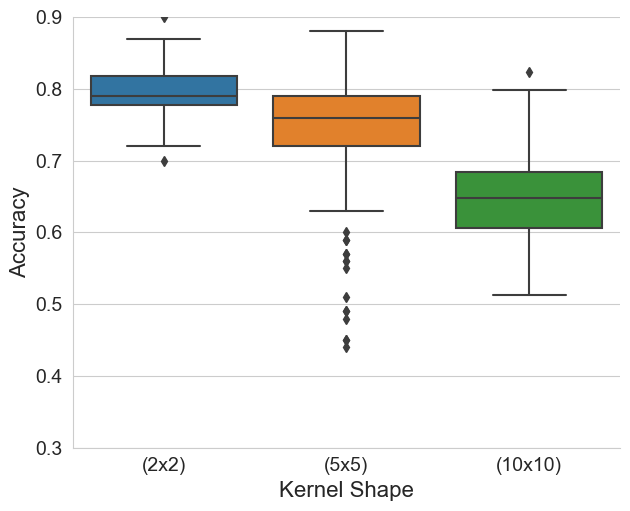

In [96]:
# 1. Box Plot showing distribution of f1_macro, precision_macro and recall_macro scores. So three plots with just kernel on
# the xaxis.

sns.set_style('whitegrid')
ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='box', height=5, aspect=1.25)
ax.tick_params(labelsize=14, axis = 'both')
ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Kernel Shape', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.3,0.9)
#plt.savefig('acc_paper_plot.jpg', dpi=2000)


In [79]:
def get_prt(df, col, kernel = 2, perc_value=25):
    return np.percentile(df[df['kernel']==kernel][col], perc_value)

In [104]:
# Here I was changing the parameters like the metric values and just changed them in the plot below. I didn't want to have
# to make a variable for each metric
ker_2_25_f1 = get_prt(results, 'accuracy_test')
ker_2_75_f1 = get_prt(results, 'accuracy_test', perc_value=75)
ker_5_25_f1 = get_prt(results, 'accuracy_test', kernel=5)
ker_5_75_f1 = get_prt(results, 'accuracy_test', kernel=5, perc_value=75)
ker_10_25_f1 = get_prt(results, 'accuracy_test', kernel=10)
ker_10_75_f1 = get_prt(results, 'accuracy_test', kernel=10, perc_value=75)

In [105]:
ker_2_25_f1, ker_2_75_f1, ker_5_25_f1, ker_5_75_f1, ker_10_25_f1, ker_10_75_f1

(0.777429467, 0.818181818, 0.72, 0.79, 0.606217617, 0.683937824)

C:\Users\User\AppData\Local\Temp\ipykernel_16840\2997361555.py:6: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='swarm', height=5, aspect=1.25, palette=palette, size=4)


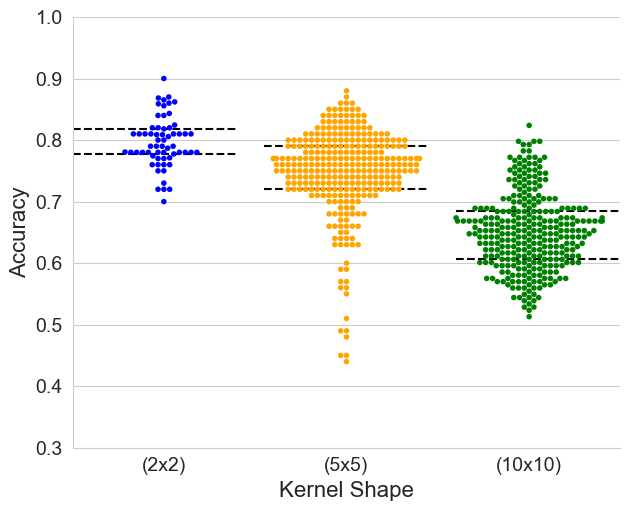

In [106]:
# 2. CDF on just Kernel. This shows the general performance of the kernel like if it's just oene kernel having a high 
# value a box plot might not show that but the cdf will show as just the 100th percentile will show that high value.

# Seems a swarmplot will be better so I ended up using a swarmplot

sns.set_style('whitegrid')
ax=sns.catplot(x='kernel', y='accuracy_test', data=results, kind='swarm', height=5, aspect=1.25, palette=palette, size=4)
ax.tick_params(labelsize=14, axis = 'both')
ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Kernel Shape', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim(0.3,1)
plt.axhline(ker_2_25_f1, 0, 0.3, color='k', linestyle='--')
plt.axhline(ker_2_75_f1, 0, 0.3, color = 'k', linestyle='--')
plt.axhline(ker_5_25_f1, 0.35, 0.65, color='k', linestyle='--')
plt.axhline(ker_5_75_f1, 0.35, 0.65, color='k',  linestyle='--')
plt.axhline(ker_10_25_f1, 0.7, 1, color='k', linestyle='--')
plt.axhline(ker_10_75_f1, 0.7, 1, color='k',  linestyle='--')
#plt.savefig('accuracy_paper_swarmm_plot.jpg', dpi=2000)


In [2]:
# 3. Blending distribution on a kernel level, x = blending, hue by kernel or column by kernel, any one.
 

## CNN result analysis

In [16]:
cnn_data = pd.read_csv('Parameter-Tuning-Results/CNN/cnn_results_all.csv')

# Convert string representation of tuple to actual tuple
cnn_data['Params'] = cnn_data['Params'].apply(ast.literal_eval)
cnn_data['test_results'] = cnn_data['test_results'].apply(ast.literal_eval)

In [17]:
cnn_data['epoch']=cnn_data['Params'].apply(slicer_1)
cnn_data['learning_rate']=cnn_data['Params'].apply(slicer_0)

In [18]:
cnn_data['f1_macro_test']=cnn_data['test_results'].apply(slicer_7)

In [19]:
cnn_data

Unnamed: 0       Params  \
0          0.0  (0.0001, 2)   
1          1.0  (0.0001, 3)   
2          2.0  (0.0001, 4)   
3          3.0  (0.0001, 5)   
4          4.0  (0.0001, 6)   
5          1.0  (0.0001, 7)   
6          2.0  (0.0001, 8)   
7          3.0  (0.0003, 2)   
8          4.0  (0.0003, 3)   
9          5.0  (0.0003, 4)   
10         6.0  (0.0003, 5)   
11         7.0  (0.0003, 6)   
12         8.0  (0.0003, 7)   
13         9.0  (0.0003, 8)   
14         NaN   (0.001, 2)   
15         NaN   (0.001, 3)   
16         NaN   (0.001, 4)   
17         NaN   (0.001, 5)   
18         NaN   (0.001, 6)   
19         NaN   (0.001, 7)   
20         NaN   (0.001, 8)   
21         NaN   (0.003, 2)   
22         NaN   (0.003, 3)   
23         NaN   (0.003, 4)   
24         NaN   (0.003, 5)   
25         NaN   (0.003, 6)   
26         NaN   (0.003, 7)   
27         NaN   (0.003, 8)   
28         NaN    (0.03, 2)   
29         NaN    (0.03, 3)   
30         NaN    (0.03, 4)   
31         NaN    (0.03, 5)   
32         NaN    (0.03, 6)   
33         NaN    (0.03, 7)   
34         NaN    (0.03, 8)   
35         NaN    (0.01, 2)   
36         NaN    (0.01, 3)   
37         NaN    (0.01, 4)   
38         NaN    (0.01, 5)   
39         NaN    (0.01, 6)   
40         NaN    (0.01, 7)   
41         NaN    (0.01, 8)   

                             train_validation_results  \
0   {'loss': [0.9495530128479004, 0.61870431900024...   
1   {'loss': [1.0189239978790283, 0.64944911003112...   
2   {'loss': [0.8098950982093811, 0.58057594299316...   
3   {'loss': [0.9511023759841919, 0.67275518178939...   
4   {'loss': [0.6717694997787476, 0.49791854619979...   
5   {'loss': [0.7025021314620972, 0.49115750193595...   
6   {'loss': [1.398436188697815, 0.874216854572296...   
7   {'loss': [0.6787029504776001, 0.33375313878059...   
8   {'loss': [0.5876633524894714, 0.29064616560935...   
9   {'loss': [0.5377100110054016, 0.28780046105384...   
10  {'loss': [0.640703558921814, 0.294321984052658...   
11  {'loss': [0.44959062337875366, 0.2245929390192...   
12  {'loss': [0.7327648401260376, 0.34067341685295...   
13  {'loss': [0.8837325572967529, 0.40188011527061...   
14  {'loss': [0.5274350047111511, 0.17400957643985...   
15  {'loss': [0.3983873128890991, 0.12797994911670...   
16  {'loss': [0.511016309261322, 0.150246098637580...   
17  {'loss': [0.5206888914108276, 0.16295267641544...   
18  {'loss': [0.5208983421325684, 0.14194490015506...   
19  {'loss': [0.4286342263221741, 0.14443634450435...   
20  {'loss': [0.5605074167251587, 0.18266560137271...   
21  {'loss': [0.2196652889251709, 0.06818754971027...   
22  {'loss': [0.24505765736103058, 0.0542757920920...   
23  {'loss': [0.47011661529541016, 0.1001667156815...   
24  {'loss': [0.24109572172164917, 0.0617166310548...   
25  {'loss': [0.3656577169895172, 0.08375398069620...   
26  {'loss': [0.2165522426366806, 0.06689756363630...   
27  {'loss': [0.3736526072025299, 0.07902259379625...   
28  {'loss': [0.41910845041275024, 0.0437127687036...   
29  {'loss': [0.7568016648292542, 0.18895646929740...   
30  {'loss': [0.7496842741966248, 0.08531656861305...   
31  {'loss': [0.5118364691734314, 0.16686964035034...   
32  {'loss': [1.1362205743789673, 0.18102949857711...   
33  {'loss': [1.3435474634170532, 0.19870290160179...   
34  {'loss': [0.8872130513191223, 0.12521462142467...   
35  {'loss': [0.2471582591533661, 0.04773751273751...   
36  {'loss': [0.1954389065504074, 0.03164922818541...   
37  {'loss': [0.36663535237312317, 0.0490929037332...   
38  {'loss': [0.24418890476226807, 0.0440803542733...   
39  {'loss': [0.24161919951438904, 0.0428733602166...   
40  {'loss': [0.5952647924423218, 0.07698239386081...   
41  {'loss': [0.3102702796459198, 0.04128718748688...   

                                         test_results  epoch  learning_rate  \
0   (0.8401253918495298, 0.8675774134790529, 0.850...      2         0.0001   
1   (0.8181818181818182, 0.6818664301939449, 0.827...      3

In [26]:
cnn_palette = {0.0001:'red', 0.0003:'blue', 0.001:'green', 0.003:'orange', 0.01:'black', 0.03:'yellow'}

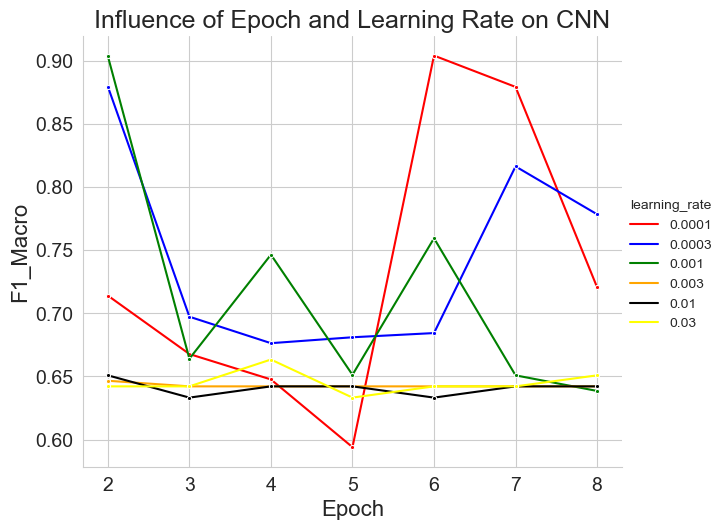

In [31]:
# 1. Line plot comparing all epochs

sns.set_style('whitegrid')
ax=sns.relplot(x='epoch', y='f1_macro_test', data=cnn_data, kind='line', hue='learning_rate',height=5, aspect=1.25, marker='.',
      palette=cnn_palette)
ax.tick_params(labelsize=14, axis = 'both')
#ax.set_xticklabels(['(2x2)', '(5x5)', '(10x10)'])
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('F1_Macro', fontsize=16)
#plt.ylim(0.3,0.9)
plt.title('Influence of Epoch and Learning Rate on CNN', fontsize=18)
#plt.savefig('f1_macro_epoch_lr.jpg', dpi=2000, bbox_inches='tight')
